# Scraping the 2011 South Africa Census

Will Geary

In [54]:
import requests
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime as dt
import os
%matplotlib inline

In [2]:
url_base = "https://census2011.adrianfrith.com"

In [3]:
# The nine provinces of South Africa
provinces = {
    "1": "Western Cape",
    "2": "Eastern Cape" ,
    "3": "Northern Cape",
    "4": "Free State",
    "5": "KwaZulu-Natal",
    "6": "North West",
    "7": "Gauteng",
    "8": "Mpumalanga",
    "9": "Limpopo"
}

# Get all of the district and metropolitan municipalities

In [4]:
starttime = dt.now()
print "start time:", starttime
    
district_municipality_ids = []

for p in provinces:
    response = requests.get(url_base + "/place/" + p)
    soup = BeautifulSoup(response.text)

    # Get place name
    
    
    # Get the last table
    table = soup.find_all("table")[-1]
    for tr in table.find_all('tr'):
        aref = tr.find_all('a')
        for a in aref:
            place_id = str(a.get('href').replace("/place/",""))
            district_municipality_ids.append(place_id)
            
finishtime = dt.now()
print "finish time:", finishtime
duration = finishtime - starttime
print "Duration:", duration

start time: 2017-10-03 10:02:03.189952


/anaconda/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /anaconda/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


finish time: 2017-10-03 10:02:12.850584
Duration: 0:00:09.660632


In [5]:
print len(district_municipality_ids), "district and metropolitan municipalities"

52 district and metropolitan municipalities


# Scrape census data for each district and metropolitan municipality

In [6]:
def scrape_census_data(place):
    gender_locIDs = []
    gender_categories = []
    gender_values = []
    gender_df = pd.DataFrame(columns=['locID', 'gender', 'people'])

    race_locIDs = []
    race_categories = []
    race_values = []
    race_df = pd.DataFrame(columns=['locID', 'race', 'people'])

    language_locIDs = []
    language_categories = []
    language_values = []
    language_df = pd.DataFrame(columns=['locID', 'language', 'people'])

    response = requests.get(url_base + "/place/" + place)
    soup = BeautifulSoup(response.text)
    locID = place
    
    number_of_tables = len(soup.find_all("table"))
    
    if number_of_tables == 4:

        # Get the first table about gender
        gender_table = soup.find_all("table")[0]
        for td in gender_table.find_all("td"):
            if '%' not in td.text:
                try:
                    value = int(td.text)
                    gender_values.append(value)
                    gender_locIDs.append(locID)
                except:
                    gender_categories.append(td.text)

        # Get the second table about race
        race_table = soup.find_all("table")[1]
        for td in race_table.find_all("td"):
            if '%' not in td.text:
                try:
                    value = int(td.text)
                    race_values.append(value)
                    race_locIDs.append(locID)
                except:
                    race_categories.append(td.text)

        # Get the third table about language
        language_table = soup.find_all("table")[2]
        count = 0
        for td in language_table.find_all("td"):
            if (('%' not in td.text) and (td.text != "")):
                if count % 2 == 0:
                    language_locIDs.append(locID)
                    language_categories.append(td.text)
                    count += 1
                else:
                    value = int(td.text)
                    language_values.append(value)
                    count += 1

        gender_df['locID'] = gender_locIDs
        gender_df['gender'] = gender_categories
        gender_df['people'] = gender_values

        race_df['locID'] = race_locIDs
        race_df['race'] = race_categories
        race_df['people'] = race_values

        language_df['locID'] = language_locIDs
        language_df['language'] = language_categories
        language_df['people'] = language_values
        
    else:
        pass
    
    return gender_df, race_df, language_df

In [7]:
starttime = dt.now()
print "start time:", starttime

gender_output = []
race_output = []
language_output = []
count = 1
for s in district_municipality_ids:
    print count, "/", len(district_municipality_ids) 
    gender, race, language = scrape_census_data(s)
    gender_output.append(gender)
    race_output.append(race)
    language_output.append(language)
    count += 1
    
gender_df = pd.concat(gender_output)
race_df = pd.concat(race_output)
language_df = pd.concat(language_output)

finishtime = dt.now()
print "finish time:", finishtime
duration = finishtime - starttime
print "Duration:", duration

start time: 2017-10-03 10:02:12.933070
1 / 52
2 / 52
3 / 52
4 / 52
5 / 52
6 / 52
7 / 52
8 / 52
9 / 52
10 / 52
11 / 52
12 / 52
13 / 52
14 / 52
15 / 52
16 / 52
17 / 52
18 / 52
19 / 52
20 / 52
21 / 52
22 / 52
23 / 52
24 / 52
25 / 52
26 / 52
27 / 52
28 / 52
29 / 52
30 / 52
31 / 52
32 / 52
33 / 52
34 / 52
35 / 52
36 / 52
37 / 52
38 / 52
39 / 52
40 / 52
41 / 52
42 / 52
43 / 52
44 / 52
45 / 52
46 / 52
47 / 52
48 / 52
49 / 52
50 / 52
51 / 52
52 / 52
finish time: 2017-10-03 10:03:04.368650
Duration: 0:00:51.435580


# Gender

In [8]:
gender = gender_df.pivot_table(index='locID', columns='gender', values='people')
cols = gender.columns
gender_pct = gender[cols].div(gender[cols].sum(axis=1), axis=0).multiply(100)

In [9]:
gender.head()

gender,Female,Male
locID,,
101,197227,194539
102,399278,388212
103,128806,129370
104,293346,280919
105,36244,34767


In [10]:
gender_pct.head()

gender,Female,Male
locID,,
101,50.343062,49.656938
102,50.702612,49.297388
103,49.890772,50.109228
104,51.081992,48.918008
105,51.039980,48.960020


In [11]:
gender.to_csv("csv/gender.csv")
gender_pct.to_csv("csv/gender_pct.csv")

# Race

In [12]:
race = race_df.pivot_table(index='locID', columns='race', values='people')
cols = race.columns
race_pct = race[cols].div(race[cols].sum(axis=1), axis=0).multiply(100)

In [13]:
race.head()

race,Black African,Coloured,Indian or Asian,Other,White
locID,,,,,
101,64110,260850,2181,3098,61527
102,186472,489189,3153,7184,101491
103,66151,139825,816,2692,48692
104,141830,311178,2526,8418,110314
105,9045,54076,300,394,7197


In [14]:
race_pct.head()

race,Black African,Coloured,Indian or Asian,Other,White
locID,,,,,
101,16.364360,66.583113,0.556710,0.790778,15.705038
102,23.679315,62.120106,0.400387,0.912267,12.887926
103,25.622444,54.158791,0.316063,1.042700,18.860002
104,24.697614,54.187084,0.439866,1.465871,19.209565
105,12.737284,76.150510,0.422464,0.554836,10.134907


In [15]:
race.to_csv("csv/race.csv")
race_pct.to_csv("csv/race_pct.csv")

# Language

In [16]:
language = language_df.pivot_table(index='locID', columns='language', values='people')
cols = language.columns
language_pct = language[cols].div(language[cols].sum(axis=1), axis=0).multiply(100)

In [17]:
language.head()

language,Afrikaans,English,Not applicable,Other,Sepedi,Sesotho,Setswana,SiSwati,Sign language,Tshivenda,Xitsonga,isiNdebele,isiXhosa,isiZulu
locID,,,,,,,,,,,,,,
101,311829,14828,19099,3043,322,4668,2358,206,1146,327,448,683,31978,833
102,568100,32815,27744,8087,678,14309,2979,295,3154,449,494,969,126087,1331
103,176037,17123,7781,3574,229,5377,1002,88,675,129,211,462,44857,629
104,397462,42266,12975,5687,654,3412,2675,296,1856,527,739,1014,102740,1960
105,60074,1789,2101,301,93,322,399,29,179,60,18,117,5346,182


In [18]:
language_pct.head()

language,Afrikaans,English,Not applicable,Other,Sepedi,Sesotho,Setswana,SiSwati,Sign language,Tshivenda,Xitsonga,isiNdebele,isiXhosa,isiZulu
locID,,,,,,,,,,,,,,
101,79.595322,3.784893,4.875079,0.776735,0.082192,1.191522,0.601887,0.052582,0.292520,0.083468,0.114353,0.174338,8.162484,0.212626
102,72.140507,4.167032,3.523088,1.026932,0.086096,1.817037,0.378290,0.037461,0.400513,0.057017,0.062731,0.123049,16.011231,0.169018
103,68.185410,6.632349,3.013859,1.384338,0.088700,2.082704,0.388110,0.034086,0.261452,0.049966,0.081728,0.178949,17.374716,0.243634
104,69.212539,7.360042,2.259418,0.990313,0.113885,0.594153,0.465814,0.051544,0.323197,0.091770,0.128687,0.176574,17.890757,0.341307
105,84.599352,2.519363,2.958738,0.423884,0.130967,0.453457,0.561893,0.040839,0.252077,0.084495,0.025349,0.164766,7.528517,0.256302


In [20]:
language.to_csv("csv/language.csv")
language_pct.to_csv("csv/language_pct.csv")

# Get KML polygons for each district and metropolitan municipality

In [39]:
starttime = dt.now()
print "start time:", starttime

count = 1
for m in district_municipality_ids:
    print count, "/", len(district_municipality_ids)
    url = "https://census2011.adrianfrith.com" + "/place/" + m +"/kml"
    urllib.urlretrieve (url, "kml/district_municipality/" + m + ".kml")
    count += 1
    
finishtime = dt.now()
print "finish time:", finishtime
duration = finishtime - starttime
print "Duration:", duration

start time: 2017-10-03 09:23:28.561639
1 / 52
2 / 52
3 / 52
4 / 52
5 / 52
6 / 52
7 / 52
8 / 52
9 / 52
10 / 52
11 / 52
12 / 52
13 / 52
14 / 52
15 / 52
16 / 52
17 / 52
18 / 52
19 / 52
20 / 52
21 / 52
22 / 52
23 / 52
24 / 52
25 / 52
26 / 52
27 / 52
28 / 52
29 / 52
30 / 52
31 / 52
32 / 52
33 / 52
34 / 52
35 / 52
36 / 52
37 / 52
38 / 52
39 / 52
40 / 52
41 / 52
42 / 52
43 / 52
44 / 52
45 / 52
46 / 52
47 / 52
48 / 52
49 / 52
50 / 52
51 / 52
52 / 52
finish time: 2017-10-03 09:25:52.468985
Duration: 0:02:23.907346


# Convert KML files to GeoJSON

In [1]:
import json
from osgeo import ogr

In [1]:
def kml2geojson(kml_file):
    drv = ogr.GetDriverByName('KML')
    kml_ds = drv.Open(kml_file)
    for kml_lyr in kml_ds:
        for feat in kml_lyr:
            return feat.ExportToJson()

In [10]:
for filename in os.listdir('kml/district_municipality/'):
    if filename == '.DS_Store':
        pass
    else:
        gj = json.loads(kml2geojson("kml/district_municipality/" + filename))
        outfile = "geojson/district_municipality/" + filename.replace("kml", "geojson")
        with open(outfile, 'a') as f:
            json.dump(gj, f)

# Merge all the geojson files into one big geojson

In [23]:
geojsons = []
for filename in os.listdir('geojson/district_municipality/'):
    if filename == '.DS_Store':
        pass
    else:
        gdf = gpd.read_file('geojson/district_municipality/'+filename)
        geojsons.append(gdf)

In [24]:
gdf = pd.concat(geojsons)
gdf = gdf.reset_index(drop=True)
gdf['locID'] = gdf['Description'].apply(lambda x: x.split(" ")[2])
gdf.index = gdf['locID']

In [25]:
gdf.head()

,Description,Name,geometry,locID
locID,,,,
101,District Municipality 101,West Coast,"(POLYGON Z ((18.78052 -30.6014700098 0, 18.784...",101
102,District Municipality 102,Cape Winelands,"(POLYGON Z ((20.1664900024 -32.2270699976 0, 2...",102
103,District Municipality 103,Overberg,"(POLYGON Z ((20.7378299976 -33.65917 0, 20.751...",103
104,District Municipality 104,Eden,"(POLYGON Z ((22.3913780005 -33.3641379968 0, 2...",104
105,District Municipality 105,Central Karoo,"(POLYGON Z ((22.6270099976 -31.8233499988 0, 2...",105


# Join census data to geographic data

In [39]:
gender_pct['locID'] = gender_pct.index
gdf_gender = pd.merge(gdf, gender_pct)
gdf_gender.head()

,Description,Name,geometry,locID,Female,Male
0,District Municipality 101,West Coast,"(POLYGON Z ((18.78052 -30.6014700098 0, 18.784...",101,50.343062,49.656938
1,District Municipality 102,Cape Winelands,"(POLYGON Z ((20.1664900024 -32.2270699976 0, 2...",102,50.702612,49.297388
2,District Municipality 103,Overberg,"(POLYGON Z ((20.7378299976 -33.65917 0, 20.751...",103,49.890772,50.109228
3,District Municipality 104,Eden,"(POLYGON Z ((22.3913780005 -33.3641379968 0, 2...",104,51.081992,48.918008
4,District Municipality 105,Central Karoo,"(POLYGON Z ((22.6270099976 -31.8233499988 0, 2...",105,51.039980,48.960020


In [37]:
race_pct['locID'] = race_pct.index
gdf_race = pd.merge(gdf, race_pct)
gdf_race.head()

,Description,Name,geometry,locID,Black African,Coloured,Indian or Asian,Other,White
0,District Municipality 101,West Coast,"(POLYGON Z ((18.78052 -30.6014700098 0, 18.784...",101,16.364360,66.583113,0.556710,0.790778,15.705038
1,District Municipality 102,Cape Winelands,"(POLYGON Z ((20.1664900024 -32.2270699976 0, 2...",102,23.679315,62.120106,0.400387,0.912267,12.887926
2,District Municipality 103,Overberg,"(POLYGON Z ((20.7378299976 -33.65917 0, 20.751...",103,25.622444,54.158791,0.316063,1.042700,18.860002
3,District Municipality 104,Eden,"(POLYGON Z ((22.3913780005 -33.3641379968 0, 2...",104,24.697614,54.187084,0.439866,1.465871,19.209565
4,District Municipality 105,Central Karoo,"(POLYGON Z ((22.6270099976 -31.8233499988 0, 2...",105,12.737284,76.150510,0.422464,0.554836,10.134907


In [38]:
language_pct['locID'] = language_pct.index
gdf_language = pd.merge(gdf, language_pct)
gdf_language.head()

,Description,Name,geometry,locID,Afrikaans,English,Not applicable,Other,Sepedi,Sesotho,Setswana,SiSwati,Sign language,Tshivenda,Xitsonga,isiNdebele,isiXhosa,isiZulu
0,District Municipality 101,West Coast,"(POLYGON Z ((18.78052 -30.6014700098 0, 18.784...",101,79.595322,3.784893,4.875079,0.776735,0.082192,1.191522,0.601887,0.052582,0.292520,0.083468,0.114353,0.174338,8.162484,0.212626
1,District Municipality 102,Cape Winelands,"(POLYGON Z ((20.1664900024 -32.2270699976 0, 2...",102,72.140507,4.167032,3.523088,1.026932,0.086096,1.817037,0.378290,0.037461,0.400513,0.057017,0.062731,0.123049,16.011231,0.169018
2,District Municipality 103,Overberg,"(POLYGON Z ((20.7378299976 -33.65917 0, 20.751...",103,68.185410,6.632349,3.013859,1.384338,0.088700,2.082704,0.388110,0.034086,0.261452,0.049966,0.081728,0.178949,17.374716,0.243634
3,District Municipality 104,Eden,"(POLYGON Z ((22.3913780005 -33.3641379968 0, 2...",104,69.212539,7.360042,2.259418,0.990313,0.113885,0.594153,0.465814,0.051544,0.323197,0.091770,0.128687,0.176574,17.890757,0.341307
4,District Municipality 105,Central Karoo,"(POLYGON Z ((22.6270099976 -31.8233499988 0, 2...",105,84.599352,2.519363,2.958738,0.423884,0.130967,0.453457,0.561893,0.040839,0.252077,0.084495,0.025349,0.164766,7.528517,0.256302


# Mapping Gender in South Africa

In [65]:
import random

In [82]:
colormaps = ['Blues','Greens', 'Oranges', 'Purples', 'Reds', 'Greys']

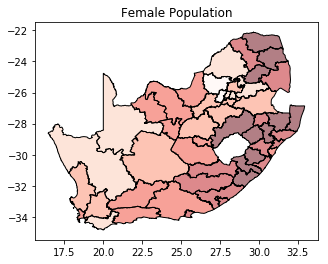

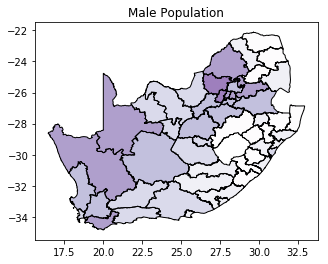

In [87]:
for col in gdf_gender.columns:
    if col not in ['Description', 'Name', 'geometry', 'locID']:
        kw = dict(column=col, k=6, colormap=random.choice(colormaps))
        ax = gdf_gender.plot(scheme='fisher_jenks', **kw)
        ax.set_title(col + " Population")

# Mapping Race in South Africa

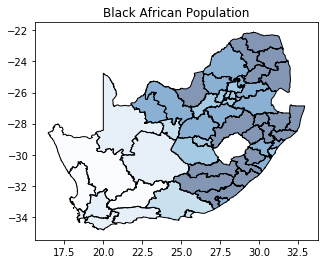

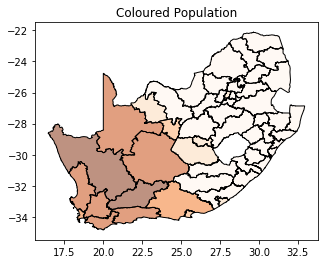

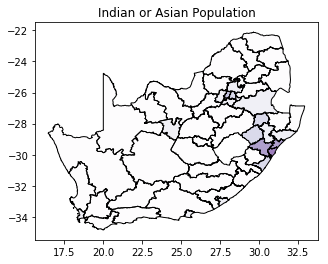

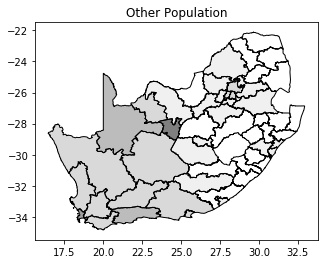

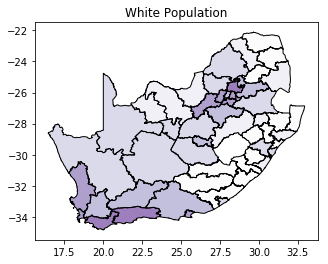

In [84]:
for col in gdf_race.columns:
    if col not in ['Description', 'Name', 'geometry', 'locID']:
        kw = dict(column=col, k=6, colormap=random.choice(colormaps))
        ax = gdf_race.plot(scheme='fisher_jenks', **kw)
        ax.set_title(col + " Population")

# Mapping Language in South Africa

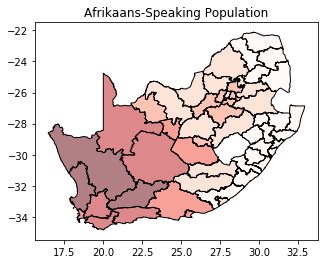

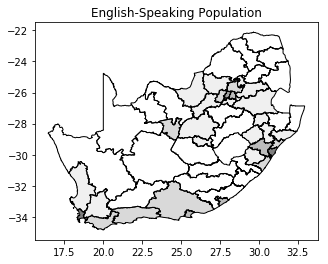

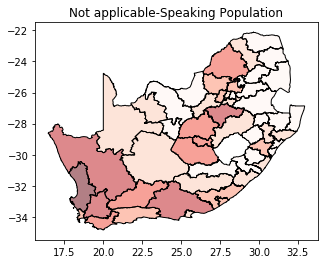

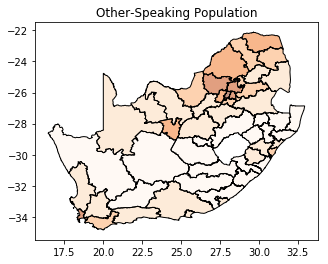

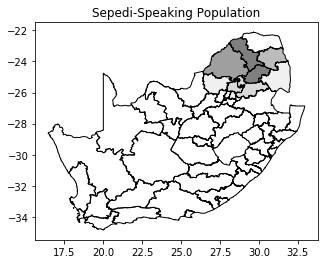

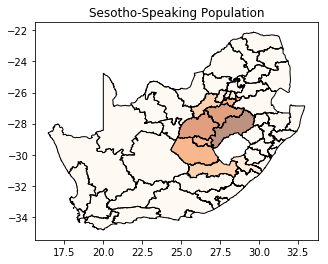

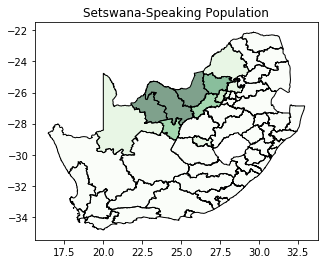

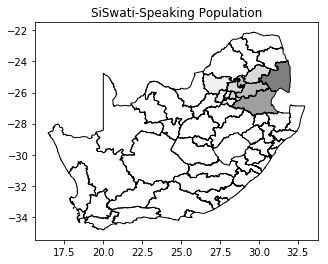

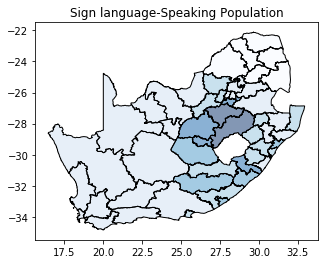

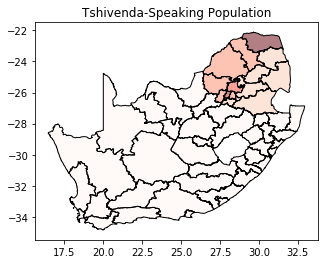

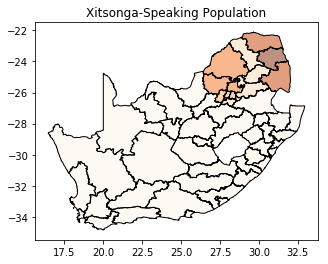

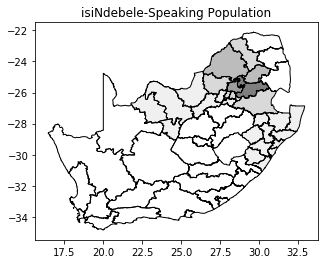

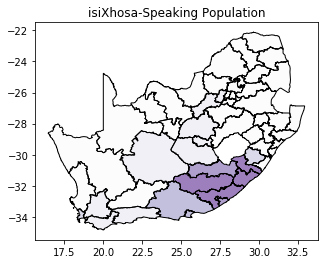

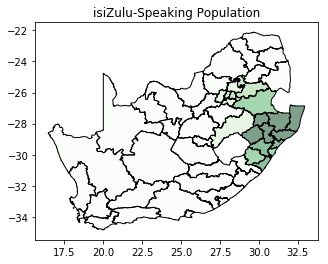

In [85]:
for col in gdf_language.columns:
    if col not in ['Description', 'Name', 'geometry', 'locID']:
        kw = dict(column=col, k=6, colormap=random.choice(colormaps))
        ax = gdf_language.plot(scheme='fisher_jenks', **kw)
        ax.set_title(col + "-Speaking Population")

# Save spatial census data to GeoJSON

In [79]:
gdf_language.to_file("language")

In [80]:
gdf_race.to_file("race")

In [81]:
gdf_gender.to_file("gender")